In [1]:
import numpy as npt
import pandas as pd
import matplotlib.pyplot as plt
# from gym import wrappers
# from gym import spaces
import math
import random
import re
import os
import sys
import seaborn as sns

In [2]:
import os

def functionfilenameandpath(path='./', extension='.em1.pcap'):
    filepaths = []
    filenames = []

    for root, _, files_list in os.walk(path):
        for file_name in files_list:
            if file_name.endswith(extension):
                file_name_path = os.path.join(root, file_name)
                filenames.append(file_name)
                filepaths.append(file_name_path)

    return filenames, filepaths
folderpath="./server_data"
filenames,filepaths=functionfilenameandpath(folderpath,'em1.pcap')

filepaths.sort()
filenames.sort()
print(filenames)

['l4s_10Mbps_20ms_ecn.em1.pcap']


In [3]:
pcap_file = filepaths[0]

In [4]:
import re

def contains_1_or_2(input_string):
    if '2' in input_string:
        return 2
    elif '1' in input_string:
        return 1
    else:
        return 0

# Example usage:
test_string = "abc123xyz"
result = contains_1_or_2(test_string)
print("Result:", result)


Result: 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


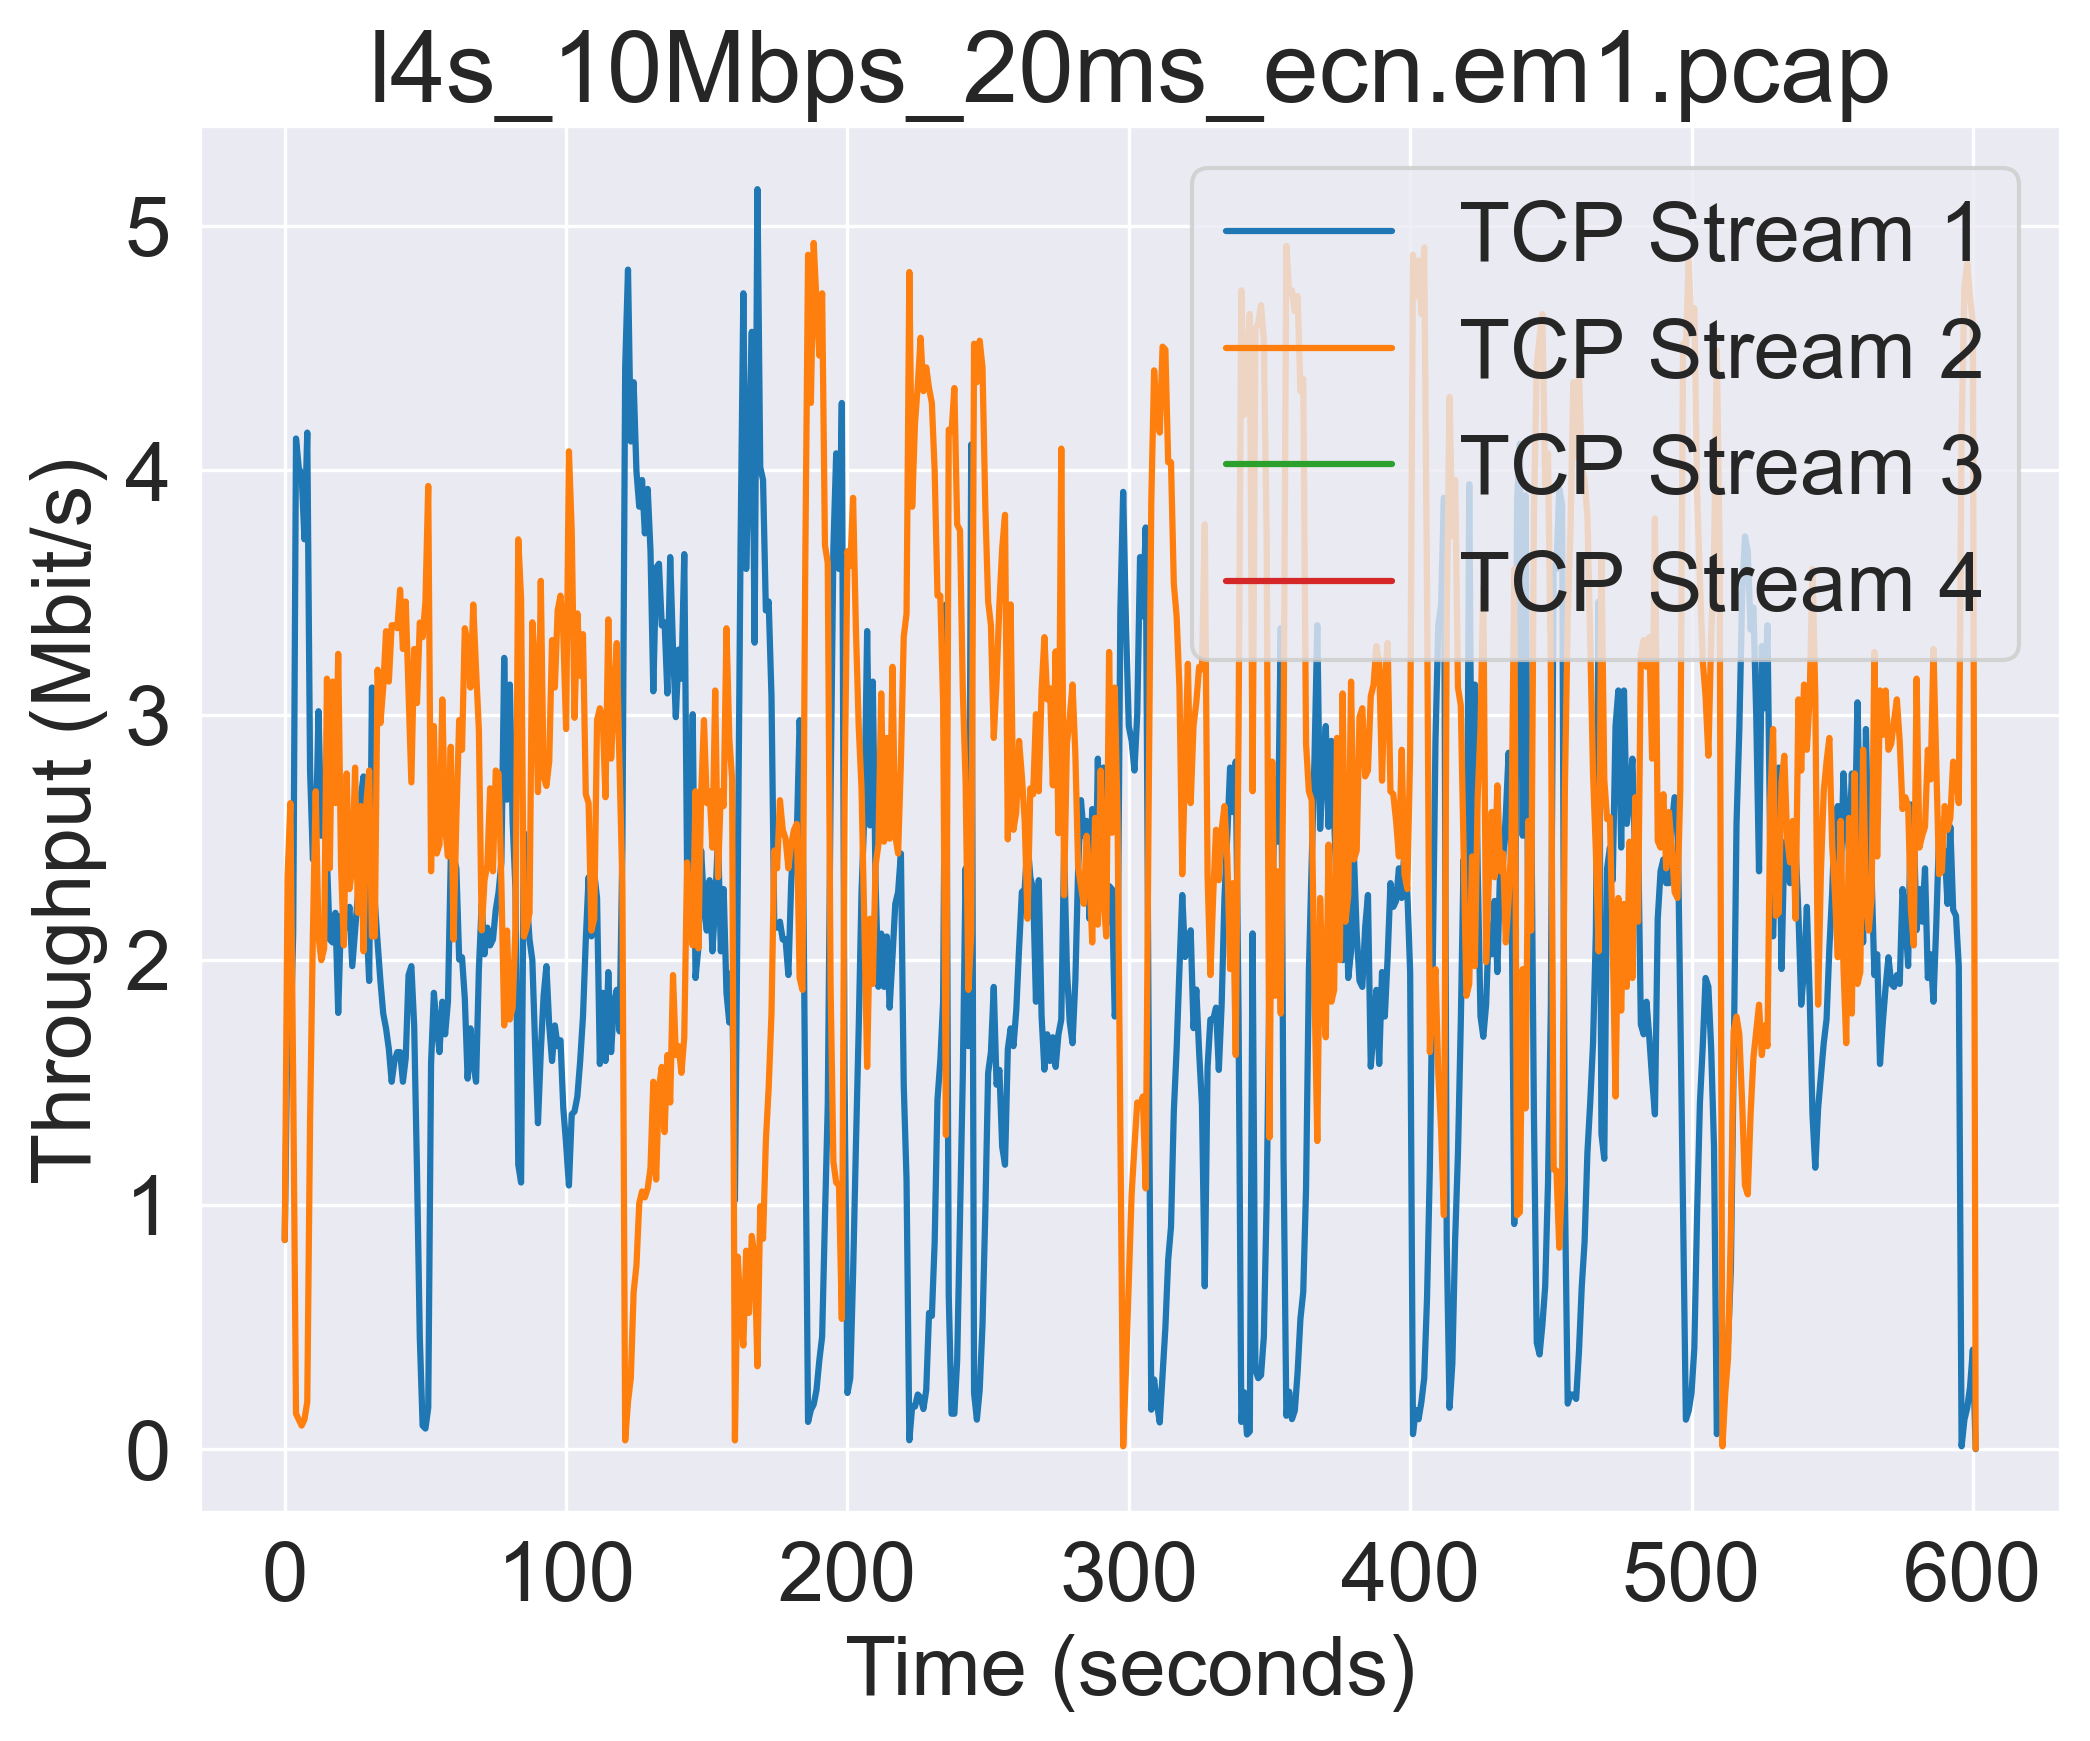

   Port 5101 (MB)  Port 5102 (MB)  Port 5103 (MB)  Port 5104 (MB)  \
0      149.794089      202.303119             0.0             0.0   

                           File  
0  l4s_10Mbps_20ms_ecn.em1.pcap  
                           File  Total Data Transferred (MB)
0  l4s_10Mbps_20ms_ecn.em1.pcap                   352.097208


In [5]:
import dpkt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    total_data_transferred = {5101: 0, 5102: 0, 5103: 0, 5104: 0}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            total_data_transferred[dest_port] += pkt_length
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second, total_data_transferred

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

def bytes_to_mb(bytes):
    return bytes / 1_000_000


total_data_per_file = []

for index in range(len(filepaths)):
    pcap_file = filepaths[index]
    throughput, total_data = read_pcap(pcap_file)

    # Prepare data for plotting
    plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 300, 'font.size': 20})
    sns.set_style("darkgrid")
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, (port, data) in enumerate(throughput.items()):
        sorted_throughput = sorted(data.items())
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        plt.plot(times, mbits_transferred, label=f'TCP Stream {i+1}', color=colors[i])
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title(filenames[index])
    plt.legend()
    plt.savefig(f"./Graphs/{filenames[index]}_Throughput.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"./Graphs/{filenames[index]}_Throughput.eps", dpi=300, bbox_inches='tight')
    plt.show()

    # Convert total data transferred to MB and add to the list
    total_data_mb = {port: bytes_to_mb(data) for port, data in total_data.items()}
    total_data_mb['File'] = filenames[index]
    total_data_per_file.append(total_data_mb)

# Convert the list to a pandas DataFrame for better visualization
df = pd.DataFrame(total_data_per_file)
df = df.rename(columns={5101: 'Port 5101 (MB)', 5102: 'Port 5102 (MB)', 5103: 'Port 5103 (MB)', 5104: 'Port 5104 (MB)'})

# Create a summary DataFrame that sums the data across all ports for each file
summary_data = {'File': [], 'Total Data Transferred (MB)': []}
for index, row in df.iterrows():
    total_data = row['Port 5101 (MB)'] + row['Port 5102 (MB)'] + row['Port 5103 (MB)'] + row['Port 5104 (MB)']
    summary_data['File'].append(row['File'])
    summary_data['Total Data Transferred (MB)'].append(total_data)

summary_df = pd.DataFrame(summary_data)

print(df)
print(summary_df)


In [6]:
df

,Port 5101 (MB),Port 5102 (MB),Port 5103 (MB),Port 5104 (MB),File
0,149.794089,202.303119,0.0,0.0,l4s_10Mbps_20ms_ecn.em1.pcap


In [7]:
summary_df

,File,Total Data Transferred (MB)
0,l4s_10Mbps_20ms_ecn.em1.pcap,352.097208


In [8]:
summary_df.to_csv("total data transferred.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


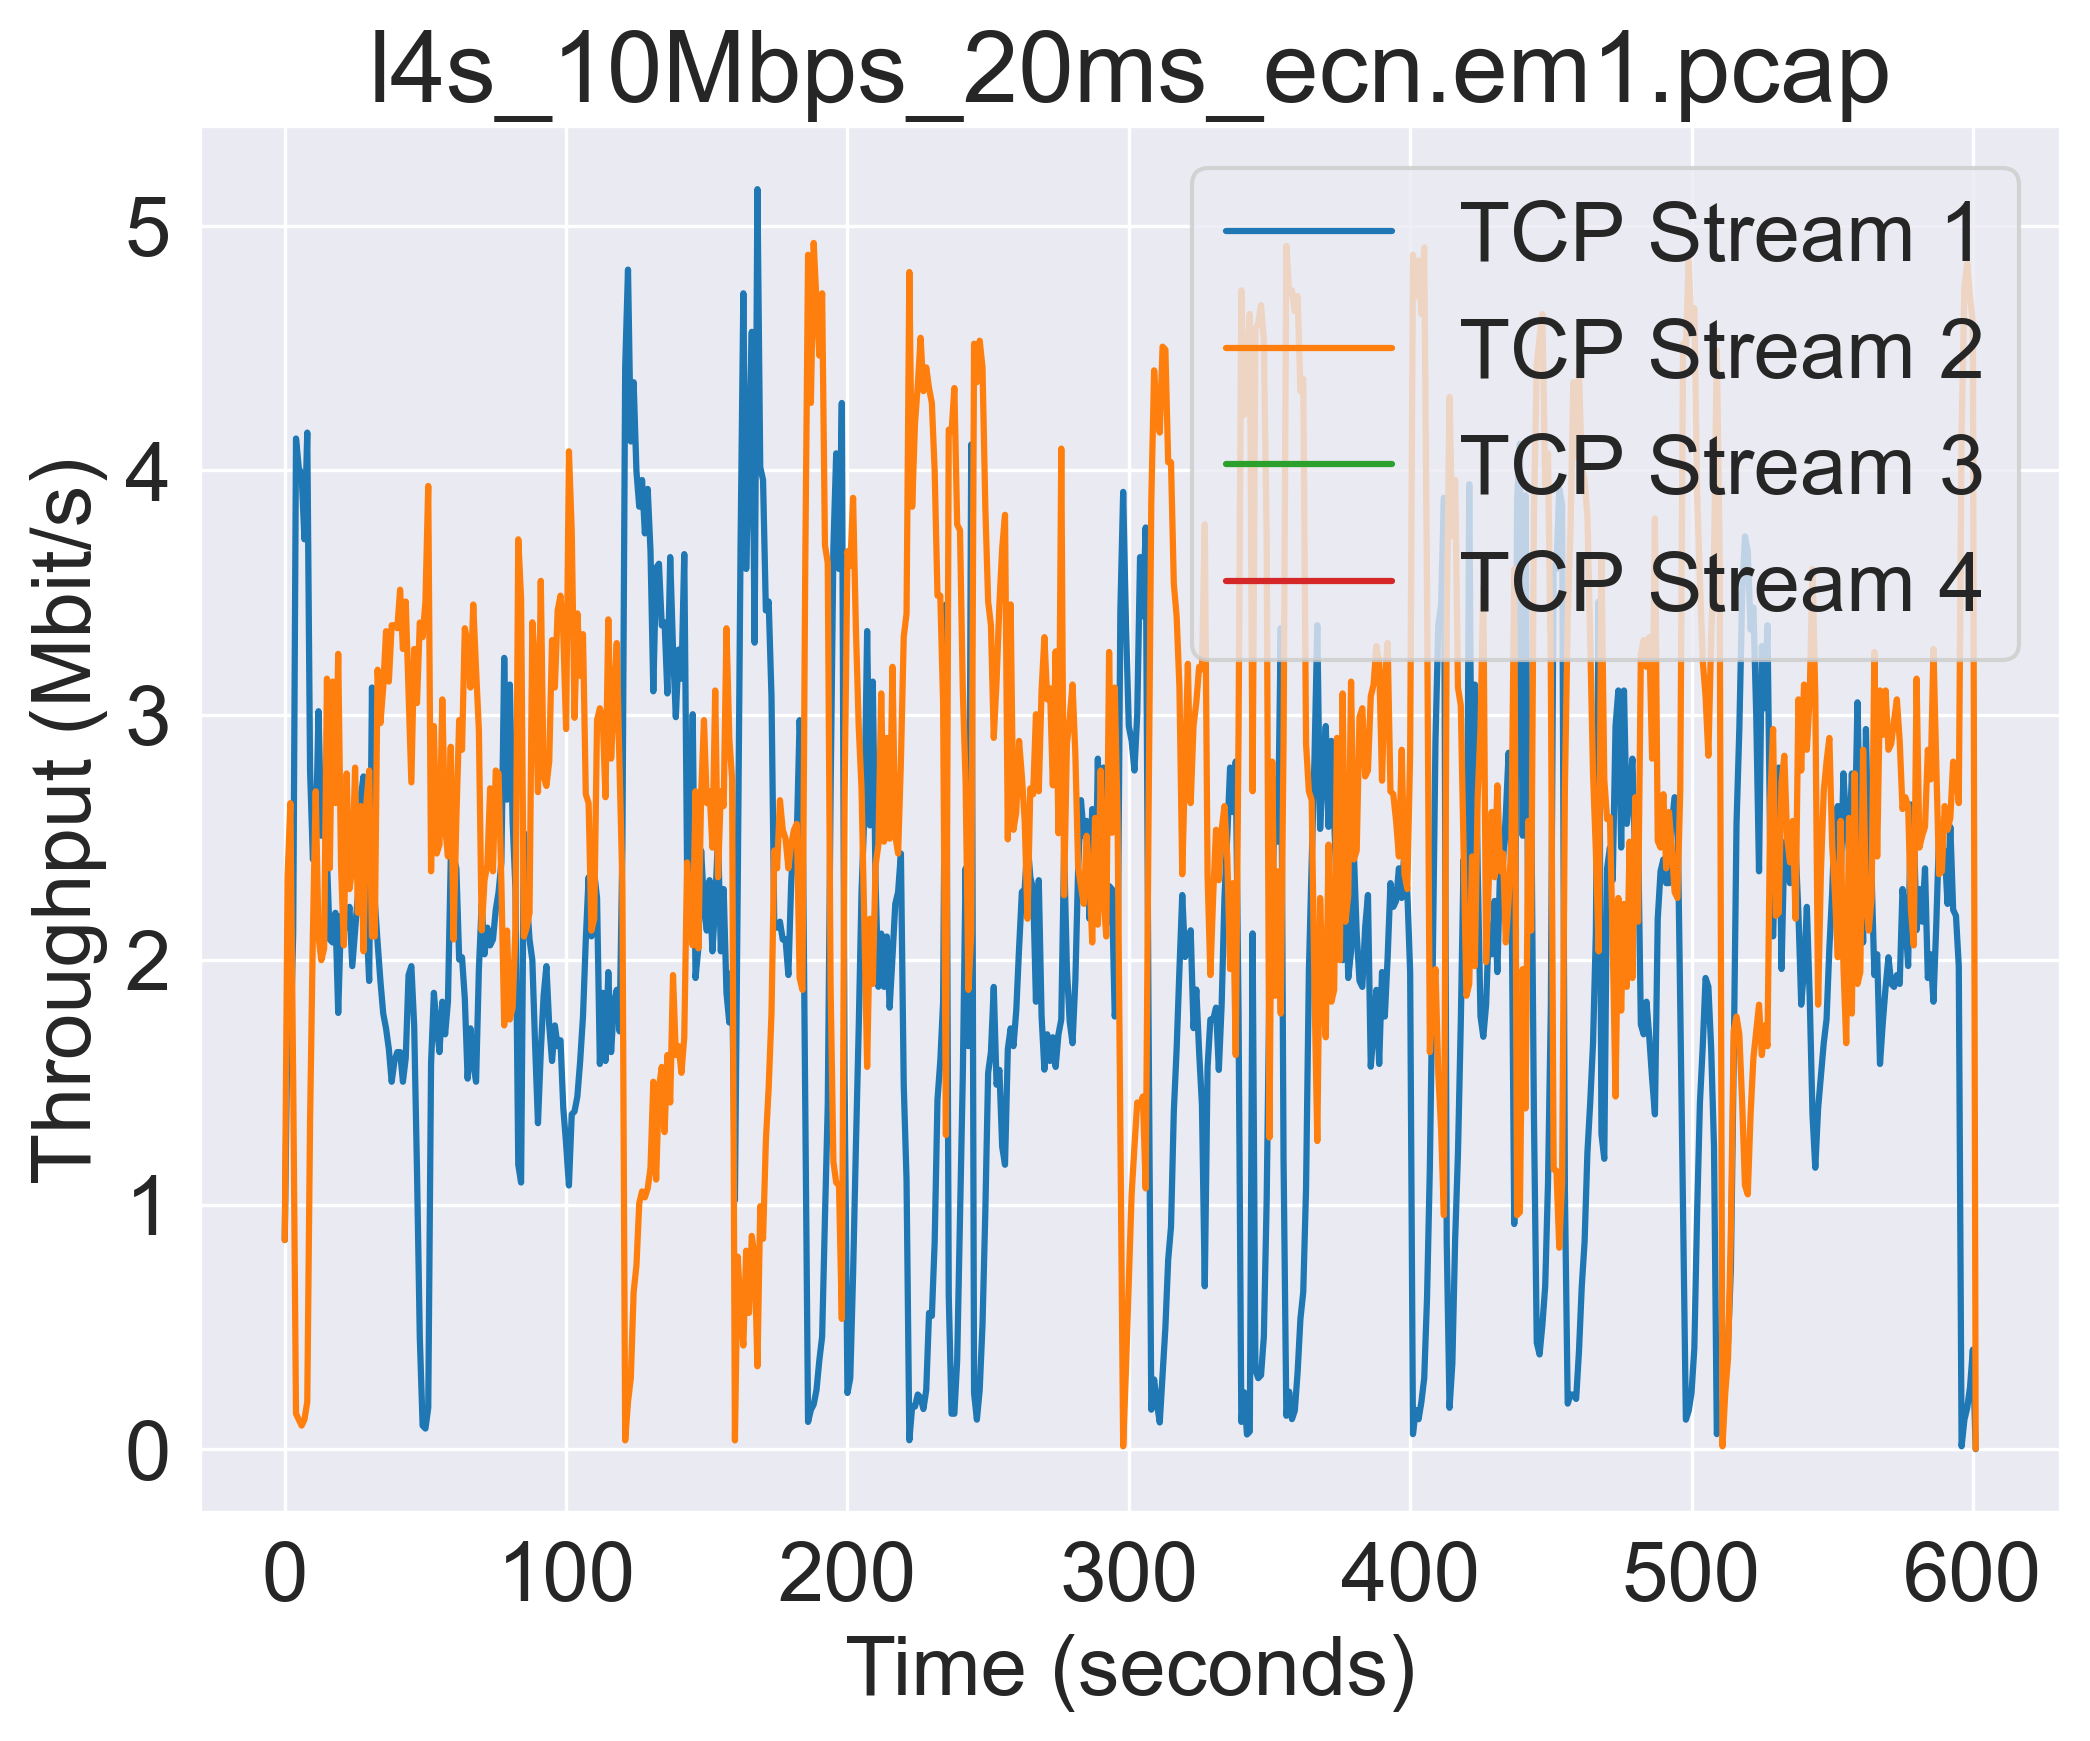

In [9]:
import dpkt
import datetime
import matplotlib.pyplot as plt

def read_pcap(file_path):
    throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            if not isinstance(ip.data, dpkt.tcp.TCP):
                continue

            tcp = ip.data
            dest_port = tcp.dport
            if dest_port not in throughput_per_second:
                continue

            pkt_length = len(buf)
            
            if start_time is None:
                start_time = timestamp

            # Normalize the timestamp to start from 0
            normalized_time = int(timestamp - start_time)
            
            if normalized_time not in throughput_per_second[dest_port]:
                throughput_per_second[dest_port][normalized_time] = pkt_length
            else:
                throughput_per_second[dest_port][normalized_time] += pkt_length
    
    return throughput_per_second

def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000



for index in range(len(filenames)):
    pcap_file = pcap_file
    throughput = read_pcap(filepaths[index])
    #plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
    plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':300, 'font.size':20})
    sns.set_style("darkgrid")  # Set the style to darkgrid
    
    # Darker color-blind-friendly palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    # Different line styles and markers
    line_styles = ['-', '--', '-.', ':']
    #line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'D']
    #markers = ['^', '^', '^', '^']

    for i, (port, data) in enumerate(throughput.items()):
        # Sort throughput dictionary by time
        sorted_throughput = sorted(data.items())
        
        times = [item[0] for item in sorted_throughput]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
        # plt.plot(times, mbits_transferred, label=f'TCP Stream {i+1}',
        #          color=colors[i], linestyle=line_styles[i])
        plt.plot(times, mbits_transferred, label=f'TCP Stream {i+1}',
                 color=colors[i])
        
    # if contains_1_or_2(filenames[index]) == 2:
    #     plt.xlim(0,100)
    #     plt.ylim(0,0.8)
    # else:
    #     plt.xlim(0,100)
    #     plt.ylim(0,5)
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (Mbit/s)')
    plt.title(filenames[index])
    plt.legend()
    plt.savefig("./Graphs/"+filenames[index]+"-"+"_Throughput.png", dpi=300,bbox_inches='tight')
    plt.savefig("./Graphs/"+filenames[index]+"-"+"_Throughput.eps", dpi=300,bbox_inches='tight')
    plt.show()


In [10]:
# import dpkt
# import datetime
# import matplotlib.pyplot as plt
# import seaborn as sns

# def read_pcap(file_path):
#     throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
#     start_time = None

#     with open(file_path, 'rb') as f:
#         pcap = dpkt.pcap.Reader(f)
        
#         for timestamp, buf in pcap:
#             eth = dpkt.ethernet.Ethernet(buf)
#             if not isinstance(eth.data, dpkt.ip.IP):
#                 continue

#             ip = eth.data
#             if not isinstance(ip.data, dpkt.tcp.TCP):
#                 continue

#             tcp = ip.data
#             dest_port = tcp.dport
#             if dest_port not in throughput_per_second:
#                 continue

#             pkt_length = len(buf)
            
#             if start_time is None:
#                 start_time = timestamp

#             # Normalize the timestamp to start from 0
#             normalized_time = int(timestamp - start_time)
            
#             if normalized_time not in throughput_per_second[dest_port]:
#                 throughput_per_second[dest_port][normalized_time] = pkt_length
#             else:
#                 throughput_per_second[dest_port][normalized_time] += pkt_length
    
#     return throughput_per_second

# def bytes_to_mbits(bytes):
#     return (bytes * 8) / 1_000_000

# def plot_throughput(throughput):
#     plt.figure(figsize=(7, 4.5))  # Set the figure size to fit within the column width
#     sns.set(style="darkgrid")  # Set the style to darkgrid
    
#     for i, (port, data) in enumerate(throughput.items()):
#         # Sort throughput dictionary by time
#         sorted_throughput = sorted(data.items())
        
#         times = [item[0] for item in sorted_throughput]
#         mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
#         plt.plot(times, mbits_transferred, label=f'Destination Port {port}')
    
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Throughput (Mbit/s)')
#     plt.title('Network Throughput Over Time for Different Streams')
#     plt.legend()
#     plt.savefig('plot.png')  # Save the plot as an image file

# # Update the path to your pcap file
# pcap_file = pcap_file
# throughput_per_second = read_pcap(pcap_file)
# plot_throughput(throughput_per_second)


In [11]:
# import dpkt
# import datetime
# import matplotlib.pyplot as plt

# def read_pcap(file_path):
#     throughput_per_second = {5101: {}, 5102: {}, 5103: {}, 5104: {}}
#     start_time = None

#     with open(file_path, 'rb') as f:
#         pcap = dpkt.pcap.Reader(f)
        
#         for timestamp, buf in pcap:
#             eth = dpkt.ethernet.Ethernet(buf)
#             if not isinstance(eth.data, dpkt.ip.IP):
#                 continue

#             ip = eth.data
#             if not isinstance(ip.data, dpkt.tcp.TCP):
#                 continue

#             tcp = ip.data
#             dest_port = tcp.dport
#             if dest_port not in throughput_per_second:
#                 continue

#             pkt_length = len(buf)
            
#             if start_time is None:
#                 start_time = timestamp

#             # Normalize the timestamp to start from 0
#             normalized_time = int(timestamp - start_time)
            
#             if normalized_time not in throughput_per_second[dest_port]:
#                 throughput_per_second[dest_port][normalized_time] = pkt_length
#             else:
#                 throughput_per_second[dest_port][normalized_time] += pkt_length
    
#     return throughput_per_second

# def bytes_to_mbits(bytes):
#     return (bytes * 8) / 1_000_000

# def plot_throughput(throughput):
#     plt.figure(figsize=(12, 8))
    
#     for port, data in throughput.items():
#         # Sort throughput dictionary by time
#         sorted_throughput = sorted(data.items())
        
#         times = [item[0] for item in sorted_throughput]
#         mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_throughput]
        
#         plt.plot(times, mbits_transferred, label=f'Destination Port {port}')
    
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Throughput (Mbit/s)')
#     plt.title(pcap_file)
#     plt.legend()
#     plt.grid()
#     plt.show()

# if __name__ == "__main__":
#     pcap_file = pcap_file
#     throughput_per_second = read_pcap(pcap_file)
#     plot_throughput(throughput_per_second)


In [12]:
# import dpkt
# import datetime
# import matplotlib.pyplot as plt

# def read_pcap(file_path):
#     throughput_per_second = {}
#     start_time = None

#     with open(file_path, 'rb') as f:
#         pcap = dpkt.pcap.Reader(f)
        
#         for timestamp, buf in pcap:
#             eth = dpkt.ethernet.Ethernet(buf)
#             if not isinstance(eth.data, dpkt.ip.IP):
#                 continue

#             ip = eth.data
#             pkt_length = len(buf)
            
#             if start_time is None:
#                 start_time = timestamp

#             # Normalize the timestamp to start from 0
#             normalized_time = int(timestamp - start_time)
            
#             if normalized_time not in throughput_per_second:
#                 throughput_per_second[normalized_time] = pkt_length
#             else:
#                 throughput_per_second[normalized_time] += pkt_length
    
#     return throughput_per_second

# def plot_throughput(throughput):
#     # Sort throughput dictionary by time
#     sorted_throughput = sorted(throughput.items())
    
#     times = [item[0] for item in sorted_throughput]
#     bytes_transferred = [item[1] for item in sorted_throughput]
    
#     plt.figure(figsize=(10, 5))
#     plt.plot(times, bytes_transferred, label='Throughput (bytes/sec)', color='blue')
#     plt.xlabel('Time (seconds)')
#     plt.ylabel('Bytes')
#     plt.title('Network Throughput Over Time')
#     plt.legend()
#     plt.grid()
#     plt.show()

# if __name__ == "__main__":
#     pcap_file = pcap_file
#     throughput_per_second = read_pcap(pcap_file)
#     plot_throughput(throughput_per_second)



In [13]:
# import dpkt
# import socket


# # Define the maximum port and window size
# def get_tcp_window_scale_option(tcp_options):
#     for opt in dpkt.tcp.parse_opts(tcp_options):
#         if opt[0] == dpkt.tcp.TCP_OPT_WSCALE:
#             scale_factor = int.from_bytes(opt[1], byteorder='big')
#             return 2 ** scale_factor
#     return 1  # Default scale if option is not present


# def analysis_pcap_tcp(pcap_file):
#     with open(pcap_file, 'rb') as f:
#         pcap = dpkt.pcap.Reader(f)
#         tcp_flows = {}
#         sender_ip = None

#         for timestamp, buf in pcap:
#             try:
#                 # Parse the packet
#                 eth = dpkt.ethernet.Ethernet(buf)
#                 # Ensure the packet is an IP packet
#                 if not isinstance(eth.data, dpkt.ip.IP):
#                     continue
#                 ip = eth.data
#                 # Ensure the packet is a TCP packet
#                 if not isinstance(ip.data, dpkt.tcp.TCP):
#                     continue
#                 tcp = ip.data

#                 # Extract relevant information from the packet
#                 src_ip = socket.inet_ntoa(ip.src)
#                 dst_ip = socket.inet_ntoa(ip.dst)

#                 # Determine if this is the first packet in the conversation to set the sender
#                 if sender_ip is None and (tcp.flags & dpkt.tcp.TH_SYN):
#                     sender_ip = src_ip  # The sender is the one who sends the first SYN
#                 if sender_ip != dst_ip and sender_ip != src_ip and (tcp.flags & dpkt.tcp.TH_SYN):
#                     sender_ip = src_ip  # The sender is the one who sends the first SYN
#                 # If this packet is not from the sender, ignore it
#                 if src_ip != sender_ip:
#                     continue

#                 # Extract the source and destination ports
#                 src_port = tcp.sport
#                 dst_port = tcp.dport

#                 # Sort IP addresses and ports to identify flows uniquely irrespective of direction.
#                 flow_id = (src_ip, src_port, dst_ip, dst_port)

#                 # Ensure flow is initialized for any TCP packet, adjusting the logic accordingly.
#                 if flow_id not in tcp_flows:
#                     tcp_flows[flow_id] = {
#                         'start_time': None, 'end_time': timestamp, 'data_bytes': 0,
#                         'transactions': [], 'handshake_complete': False, 'packet_count': 0, 
#                         'flow_tuple': flow_id, 'window_scale': 1, 'syn': False, 'fin': False,
#                         'initial_rtt': None, 'rtt_estimation': None, 'cwnd_packets': [], 
#                         'last_packet_time': None, 'ack_freq': {}, 'seq_numbers': {},   
#                         'triple_dup_acks': 0, 'timeouts': 0, 'retransmissions': -1, 'seen_seqs': {},
#                     }

#                 # Get the flow object
#                 flow = tcp_flows[flow_id]
#                 flow['end_time'] = timestamp

#                 # Update the flow information
#                 if flow['start_time'] is None and tcp.flags & dpkt.tcp.TH_SYN:
#                     flow['start_time'] = timestamp  # Set the start time of the flow
#                     flow['window_scale'] = get_tcp_window_scale_option(tcp.opts) # Get the window scale option
#                 if flow['start_time'] is not None:
#                     flow['data_bytes'] += len(tcp)
#                     flow['packet_count'] += 1
                    
#                 # Check for handshake completion
#                 if tcp.flags & dpkt.tcp.TH_SYN and not tcp.flags & dpkt.tcp.TH_ACK:
#                     flow['syn'] = True
#                 if tcp.flags & dpkt.tcp.TH_ACK and flow['syn'] and not flow['handshake_complete']:
#                     flow['handshake_complete'] = True

#                 # Check for flow termination
#                 if tcp.flags & dpkt.tcp.TH_FIN | dpkt.tcp.TH_RST:
#                     flow['fin'] = True
                
                
#                 # Check for data packets
#                 if flow['handshake_complete'] and len(tcp.data) > 0:
#                     # Add the transaction to the flow if one of first 2
#                     if len(flow['transactions']) < 2:
#                         flow['transactions'].append((tcp.seq, tcp.ack, tcp.win * flow['window_scale']))

#                 # Adjusting logic to capture initial RTT and counting packets per RTT
#                 if tcp.flags & dpkt.tcp.TH_SYN and not flow['initial_rtt']:
#                     flow['last_packet_time'] = timestamp  # Mark the time of the SYN packet
#                 elif tcp.flags & dpkt.tcp.TH_ACK and flow['syn'] and not flow['initial_rtt']:
#                     # Assuming this ACK is part of the handshake completion
#                     flow['initial_rtt'] = timestamp - flow['last_packet_time']  # Initial RTT estimation
#                     flow['rtt_estimation'] = flow['initial_rtt']  # Storing initial RTT as the estimate
#                     flow['last_packet_time'] = timestamp  # Resetting for packet counting

#                 # Logic to count packets per estimated RTT
#                 if flow['initial_rtt']:
#                     time_since_last_packet = timestamp - flow['last_packet_time']
#                     if time_since_last_packet < flow['rtt_estimation']:
#                         # Still within the same RTT, count the packet
#                         if len(flow['cwnd_packets']) == 0:
#                             flow['cwnd_packets'].append(1)  # Starting the first count
#                         else:
#                             flow['cwnd_packets'][-1] += 1  # Increment current RTT's packet count 
#                             pass
#                     else:
#                         # New RTT period, reset packet count
#                         if len(flow['cwnd_packets']) < 4:  # Only if we need more CWND sizes
#                             flow['cwnd_packets'].append(1)  # Start counting for a new CWND size
#                         flow['last_packet_time'] = timestamp  # Resetting for next RTT counting

#                 if (tcp.flags & dpkt.tcp.TH_ACK) and not (tcp.flags & dpkt.tcp.TH_SYN):
#                     ack = tcp.ack
#                     # Track ACKs for triple duplicate detection
#                     if ack not in flow['ack_freq']:
#                         flow['ack_freq'][ack] = 1
#                     else:
#                         flow['ack_freq'][ack] += 1
#                         current_ack_freq = flow['ack_freq'][ack]
#                         if current_ack_freq == 4:  # Triple duplicate ACK detected
#                             flow['triple_dup_acks'] += 1

#                 # Track sequence numbers to identify retransmissions
#                 if tcp.seq not in flow['seq_numbers']:
#                     flow['seq_numbers'][tcp.seq] = timestamp
#                 else:
#                     # Check if the packet is a retransmission
#                     if timestamp - flow['seq_numbers'][tcp.seq] > 2 * flow['rtt_estimation']: # Timeout threshold
#                         flow['timeouts'] += 1

#                 # Track sequence numbers to detect retransmissions
#                 seq = tcp.seq
#                 if flow['handshake_complete'] and seq in flow['seen_seqs'] and flow['seen_seqs'][seq] is True:
#                     # If the sequence number has been seen before, it's a retransmission
#                     flow['retransmissions'] += 1
#                     flow['seen_seqs'][seq] = False
#                 elif flow['handshake_complete']:
#                     # Otherwise, mark the sequence number as seen
#                     flow['seen_seqs'][seq] = True

#             except Exception as e:
#                 # Print the error and continue to the next packet
#                 print(f"Error processing packet: {e}")

#     # Output results
#     print(f"\nNumber of TCP flows initiated from the sender: {len(tcp_flows)}\n")
#     flow_count = 1
#     for flow_id, data in tcp_flows.items():
#         print(f"Flow {flow_count}:")
#         flow_count += 1
#         print(f"  Source IP: {data['flow_tuple'][0]}, Source Port: {data['flow_tuple'][1]} -> Destination IP: {data['flow_tuple'][2]}, Destination Port: {data['flow_tuple'][3]}")
#         for i, transaction in enumerate(data['transactions'], 1):
#             seq_num, ack_num, rec_win_size = transaction
#             print(f"  Transaction {i}: Seq Num: {seq_num}, Ack Num: {ack_num}, Rec Win Size: {rec_win_size}")
#         if 'end_time' in data and data['end_time'] is not None:
#             duration = data['end_time'] - data['start_time']
#             throughput = data['data_bytes'] / duration if duration > 0 else 0
#             print(f"  Sender Throughput: {throughput} bytes/sec")
#             print(f"  == ({data['data_bytes']} bytes sent in {data['end_time'] - data['start_time']} seconds)")
#             print(f"  First 3 Congestion Window Sizes: {data['cwnd_packets'][0:3]}")
#             print(f"  Retransmissions due to Triple Duplicate ACKs: {data['retransmissions'] - data['timeouts']}")
#             print(f"  Retransmissions due to Timeouts: {data['timeouts']}")
#         else:
#             print("  Incomplete flow.")
#         print()


# analysis_pcap_tcp(pcap_file)

In [14]:
import os

def functionfilenameandpath(path='./', extension='.em1.pcap'):
    filepaths = []
    filenames = []

    for root, _, files_list in os.walk(path):
        for file_name in files_list:
            if file_name.endswith(extension):
                file_name_path = os.path.join(root, file_name)
                filenames.append(file_name)
                filepaths.append(file_name_path)

    return filenames, filepaths
folderpath="./server_data"
filenames,filepaths=functionfilenameandpath(folderpath,'em1.pcap')

filepaths.sort()
filenames.sort()
print(filenames)

['l4s_10Mbps_20ms_ecn.em1.pcap']
